In [1]:
from collections import defaultdict
import re
import pandas as pd
import numpy as np

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

from matplotlib import cm
import seaborn as sns

import treeswift as ts

# Analysis of the expression of FiNZ-ZnF genes
KRAB-ZnFs in mammals are known to be expressed during early development, which is consistent with the fact that retrolements are often highly expressed during this period. Previous observations from White et al. (2017) have shown that FiNZ-ZnF genes are expressed in a burst immediately following zygotic genome activation. Along with several other strands of information, this supports the hypothesis that 

In [2]:
def load_sample_info():
    """Return metadata including biological replicate accessions, stage info and sequencing type."""
    sample_df = pd.read_csv('../data/expression/White2017/elife-30860-supp1-v1.tsv', sep='\t')
    sample_df = sample_df.rename({'accession_number': 'sampleAccession'}, axis=1)
    return sample_df

def load_counts(tecountsfile):
    """Return DataFrame with gene and read count info."""
    accession = re.search('(ERS\d+)\.', tecountsfile).group(1)
    tecount_df = pd.read_csv(tecountsfile, skiprows=1, header=None, names=['gene', 'reads'], sep='\t')
    tecount_df['gene'] = tecount_df['gene'].apply(lambda x: x.split(':')[0])
    tecount_df[accession] = tecount_df['reads']
    return tecount_df[['gene', accession]]

def load_gene_lengths():
    """Return dictionary containing gene lengths.
    
    Gene length is calculated as the length of the union of exons. For genes, this is the median length
    of each transcript, and for TEs, the total merged length of all fragments for each family. See 
    """
    gl_df = pd.read_csv('../data/expression/danRer11.nonalt.genes_tes.lengths.txt', sep='\t')
    gl_df['genetype'] = 'gene'
    gl_df.loc[gl_df.gene.str.match(r'^g\d{1,4}'), 'genetype'] = 'FiNZ-ZnF'
    gl_df.loc[(gl_df.genetype != 'FiNZ-ZnF') & ~(gl_df.gene.str.startswith('ENSDARG')), 'genetype'] = 'TE'
    gl_df['length'] = gl_df['median']
    gl_df.loc[gl_df.genetype == 'TE', 'length'] = gl_df['merged']
    genelengths = dict(zip(gl_df['gene'], gl_df['length']))
    return genelengths

def calc_tpm(counts_df, genelengths):
    """Convert counts to TPM"""
    # Collapse biological replicates by summing counts
#     tpm_df = counts_df.groupby(['stageName', 'gene', 'sampleAccession']) \
#                    .sum() \
#                    .reset_index()
    tpm_df = counts_df.copy()
    # Calculate TPM
    ascale = tpm_df.groupby('stageName')['counts'].sum()/1e06
    ascale = dict(zip(ascale.reset_index().stageName, ascale.reset_index().counts))
    tpm_df['len'] = tpm_df['gene'].apply(lambda x: genelengths[x])
    tpm_df['rpk'] = tpm_df['counts']/(tpm_df['len']/1000)
    tpm_df['ascale'] = tpm_df['stageName'].apply(ascale.get)
    tpm_df['tpm'] = tpm_df['rpk']/tpm_df['ascale']
    tpm_df = tpm_df.drop(['rpk', 'ascale', 'len', 'counts'], axis=1)
    return tpm_df


In [3]:
# Load list of sample accessions
sample_df = load_sample_info()
accessions = sample_df.loc[sample_df.sequencing == 'RNASeq', 'sampleAccession']

# Populate dataframe of all counts
countdata = []
for acc in accessions:
    countdata.append(load_counts(f'../data/expression/TEcount-out/{acc}.cntTable'))
counts_df = pd.concat(countdata, axis=1, join='inner') \
              .drop('gene', axis=1)
counts_df['gene'] = countdata[0]['gene']
counts_df = counts_df.melt(id_vars='gene', var_name='sampleAccession', value_name='counts')
counts_df = counts_df.merge(sample_df[['sampleAccession', 'stageName']], 
                            on='sampleAccession', 
                            how='left')

# Convert to TPM
tpm_df = calc_tpm(counts_df, load_gene_lengths())

# Sort by stage order
stageorder = ['1-cell', 
             '2-cell', 
             '128-cell', 
             '1k-cell', 
             'Dome', 
             '50pc-epiboly', 
             'Shield', 
             '75pc-epiboly', 
             '1-4-somites', 
             '14-19-somites', 
             '20-25-somites',
             'Prim-5',
             'Prim-15',
             'Prim-25',
             'Long-pec',
             'Protruding-mouth',
             'Day-4',
             'Day-5']
tpm_df['stageName'] = pd.Categorical(tpm_df['stageName'], stageorder)
tpm_df = tpm_df.groupby(['gene', 'stageName']).mean().reset_index()
tpm_df = tpm_df.sort_values(['gene', 'stageName'])
print(tpm_df.loc[tpm_df.gene == 'BHIKHARI_LTR'].head(10))

              gene      stageName        tpm
2862  BHIKHARI_LTR         1-cell   0.001565
2863  BHIKHARI_LTR         2-cell   0.007935
2864  BHIKHARI_LTR       128-cell   0.013892
2865  BHIKHARI_LTR        1k-cell   0.023210
2866  BHIKHARI_LTR           Dome   3.221342
2867  BHIKHARI_LTR   50pc-epiboly   9.044346
2868  BHIKHARI_LTR         Shield  13.909011
2869  BHIKHARI_LTR   75pc-epiboly  11.581647
2870  BHIKHARI_LTR    1-4-somites   2.265478
2871  BHIKHARI_LTR  14-19-somites   1.446833


In [4]:
finz = []
with open('../data/seqs/Danio_rerio_hiqual_finz.aa.fa') as infile:
    for line in infile:
        finz_gene = re.search('>(g\d+).t1', line)
        if finz_gene:
            finz.append(finz_gene.group(1))
            
            
expressed = set(tpm_df.loc[(tpm_df.tpm >= 1) & (tpm_df.gene.isin(finz)), 'gene'].to_list())
print(len(set(finz)))
print(len(expressed))

tpm_df['finz'] = False
tpm_df.loc[tpm_df.gene.isin(finz), 'finz'] = True
tpm_df['expressed'] = False
tpm_df.loc[tpm_df.gene.isin(expressed), 'expressed'] = True

684
168


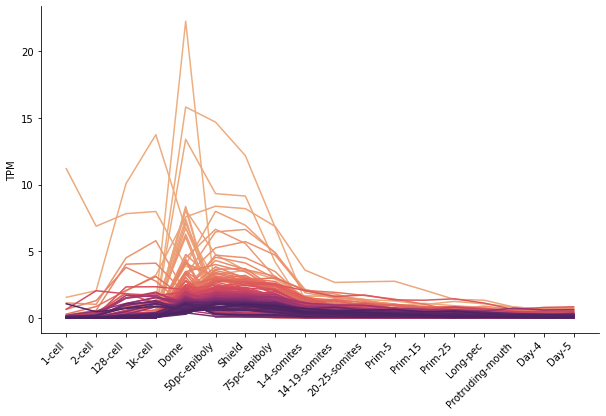

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

hue_order = list(tpm_df.loc[tpm_df.expressed == True].groupby('gene').max().reset_index().sort_values('tpm')['gene'])

sns.lineplot(data=tpm_df.loc[tpm_df.expressed == True],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             hue_order=hue_order[::-1],
             palette='flare',
             lw=1.5,
             ax=ax)

ax.get_legend().remove()
ax.set_ylabel('TPM')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()
fig.savefig('../figs/fznf_expression.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/fznf_expression.png', bbox_inches='tight', dpi=300)

# Identification of Early-Late expression clusters

In [6]:
finz_matrix = tpm_df[['gene', 'stageName', 'tpm']].loc[tpm_df['gene'].isin(expressed)].copy()
finz_matrix = finz_matrix[['gene', 'stageName', 'tpm']].set_index('gene')
finz_matrix = finz_matrix.pivot(columns='stageName', values='tpm')

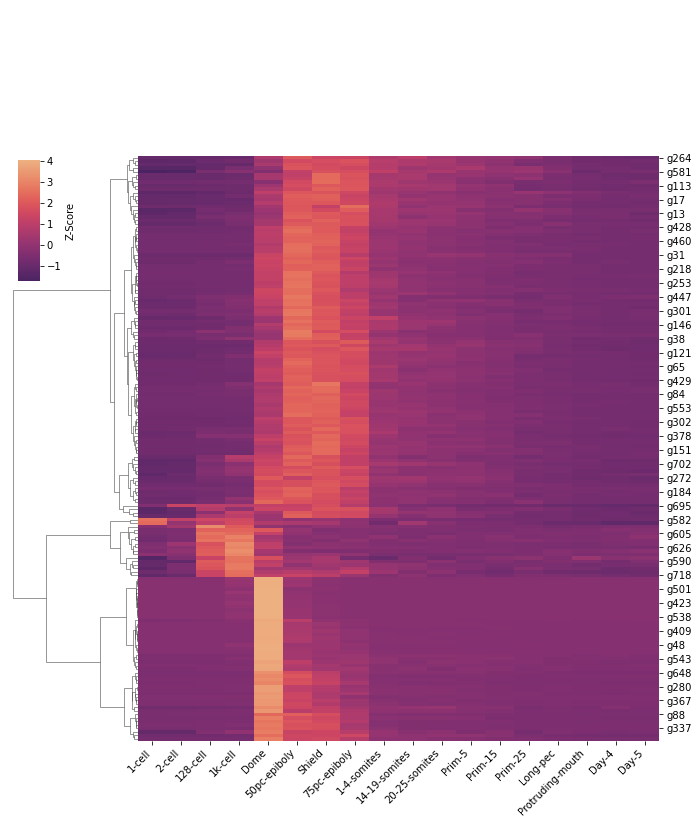

In [7]:
cg = sns.clustermap(data=finz_matrix, 
                     cmap="flare_r", 
                     col_cluster=False,
                     method='ward',
                     z_score=0,
                     cbar_pos=(0.03, 0.67, 0.03, 0.14),
                     figsize=(10, 12))
legend = cg.fig.gca()
ax = cg.ax_heatmap
legend.set_ylabel('Z-Score')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(stageorder, rotation=45, ha='right')
plt.show()
cg.savefig('../figs/fznf_clustermap.pdf', bbox_inches='tight', dpi=300)
cg.savefig('../figs/fznf_clustermap.png', bbox_inches='tight', dpi=300)

In [8]:
# Now extract the cluster information from the dendrogram and save the TPM dataframe
nclusts = 3
clusters = {}
cluster_labels = {1.0: 'Maternally deposited', 2.0: 'Dome', 0.0: 'Late', 3.0: 'X', 4.0: 'Y', 5.0: 'Z'}
for pair in zip(cut_tree(cg.dendrogram_row.linkage, nclusts), finz_matrix.index):
    clusters[pair[1]] = cluster_labels[pair[0][0]]
tpm_df['cluster'] = None
tpm_df['cluster'] = tpm_df['gene'].apply(lambda x: clusters.get(x, 'NC'))
tpm_df.to_csv('../data/finz_expression_tpm.txt', sep='\t', index=False)

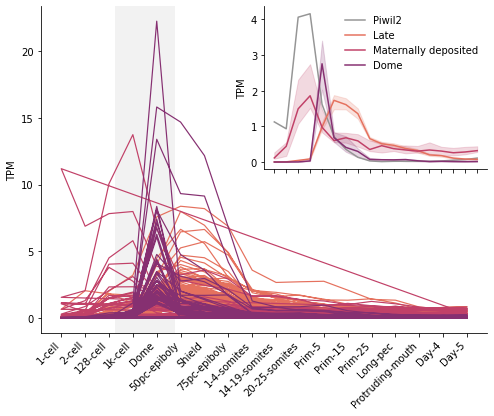

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
axin1 = ax.inset_axes([0.5, 0.5, 0.5, 0.5])
ax.axvline(x=3.5, lw=60, alpha=0.1,color='gray')

tpm_df['genename'] = ''
tpm_df.loc[tpm_df.gene == 'ENSDARG00000062601', 'genename'] = 'Piwil2'

sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(expressed)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='cluster',
             palette='flare',
             lw=1.2,
             estimator=None,
             ax=ax)

sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(['ENSDARG00000062601'])],
             x='stageName', 
             y='tpm', 
             sort=False,
             lw=1.5,
             hue='genename',
             palette='Greys',
             ax=axin1)
sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(expressed)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='cluster',
             palette='flare',
             estimator=np.median,
             ci=90,
             lw=1.5,
             ax=axin1)

ax.set_xlabel('')
ax.set_ylabel('TPM')
plt.xticks(rotation=45, ha='right')
ax.get_legend().remove()

axin1.legend(frameon=False)
axin1.set_ylabel('TPM')
axin1.set_xlabel('')
axin1.set_xticklabels([])
axin1.spines['right'].set_visible(False)
axin1.spines['top'].set_visible(False)

sns.despine()
plt.show()
fig.savefig('../figs/fznf_cluster_expression.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/fznf_cluster_expression.png', bbox_inches='tight', dpi=300)

In [10]:
midpoints = {}
chroms = {}
with open('../data/gffs/Danio_rerio_hiqual_finz.gff') as infile:
    infile.readline()
    for line in infile:
        if line.startswith('#'):
            continue
        line = line.split()
        if line[2] != 'gene':
            continue
        gene = line[-1].strip('ID=')
        midpoint = round(min(float(line[3]), float(line[4])) + abs(float(line[4]) - float(line[3]))/2.0)
        midpoints[gene] = midpoint
        chroms[gene] = line[0]
with open('../data/beds/Danio_rerio.genome') as infile:
    chromsizes={i.split()[0]: int(i.split()[1]) for i in infile}
    
# Generate location dataframe
finz_locs_df = tpm_df.loc[(tpm_df.gene.isin(finz)) & (tpm_df.stageName == 'Dome')].copy()
finz_locs_df['chromosome'] = finz_locs_df.gene.apply(chroms.get)
finz_locs_df['position'] = finz_locs_df.gene.apply(midpoints.get)

/Users/jonwells/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1138: UserWarning: You passed a edgecolor/edgecolors ('#373737') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(strip_data, cat_pos, **kws)
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


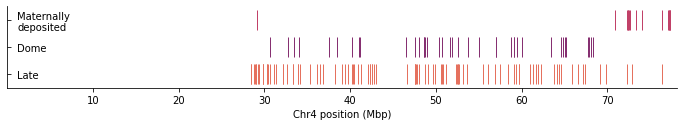

In [11]:
flare = cm.get_cmap('flare', 5)
fig, ax = plt.subplots(figsize=(12, 1.5))
sns.stripplot(data=finz_locs_df.loc[(finz_locs_df.chromosome == 'NC_007115.7') & (finz_locs_df.gene.isin(expressed))],
              x='position',
              y='cluster',
              palette=[flare(2), flare(3), flare(1)],
              order=['Maternally deposited', 'Dome', 'Late'],
              hue_order=['Maternally deposited', 'Dome', 'Late'],
              linewidth=1,
              jitter=0,
              marker='|', size=20)

ax.set_yticklabels(['Maternally\ndeposited', 'Dome', 'Late'])
ax.set_ylabel('')
ax.set_xlabel('Chr4 position (Mbp)')
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_xlim((1, chromsizes['NC_007115.7']))
ax.tick_params(axis="y",direction="in", pad=-10)
plt.yticks(ha='left')

sns.despine()
plt.show()
fig.savefig('../figs/fznf_cluster_location.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/fznf_cluster_locations.png', bbox_inches='tight', dpi=300)



In [12]:
tree = open('../data/selection-analysis/pairwise_needleman_longlabel.nwk').read().replace('\n', '')
tree = ts.read_tree(tree, 'Newick')
leaves = [node.label for node in tree.traverse_leaves()]
tree_df = pd.DataFrame(leaves, columns=['label'])
tree_df['species'] = tree_df.label.apply(lambda x: '_'.join(x.split('_')[:2]))
tree_df['gene'] = tree_df.label.apply(lambda x: re.search('_(g\d{1,4})\.t1_', x).group(1))
tree_df = tree_df.loc[tree_df.species == 'Danio_rerio'] \
    .merge(tpm_df.loc[tpm_df.stageName == 'Dome'].drop('genename', 1), on='gene')
brlens = {label.strip("'"): node.get_edge_length() for label, node in tree.label_to_node().items()}
tree_df['brlens'] = tree_df.label.apply(brlens.get)
print(tree_df.head())

                           label      species  gene stageName       tpm  finz  \
0    Danio_rerio_g5.t1_[len=265]  Danio_rerio    g5      Dome  0.283404  True   
1  Danio_rerio_g392.t1_[len=207]  Danio_rerio  g392      Dome  0.020022  True   
2  Danio_rerio_g228.t1_[len=291]  Danio_rerio  g228      Dome  0.083639  True   
3   Danio_rerio_g55.t1_[len=291]  Danio_rerio   g55      Dome  0.129154  True   
4  Danio_rerio_g516.t1_[len=291]  Danio_rerio  g516      Dome  0.033998  True   

   expressed cluster   brlens  
0      False      NC  0.06609  
1      False      NC -0.00870  
2      False      NC  0.01194  
3      False      NC  0.00000  
4      False      NC  0.00000  


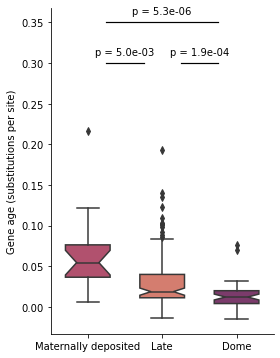

In [13]:
mvd = stats.ranksums(tree_df.loc[tree_df.cluster == 'Maternally deposited', 'brlens'],
                     tree_df.loc[tree_df.cluster == 'Dome', 'brlens'])[1]
mvl =stats.ranksums(tree_df.loc[tree_df.cluster == 'Maternally deposited', 'brlens'],
                     tree_df.loc[tree_df.cluster == 'Late', 'brlens'])[1]
dvl = stats.ranksums(tree_df.loc[tree_df.cluster == 'Dome', 'brlens'],
                     tree_df.loc[tree_df.cluster == 'Late', 'brlens'])[1]

fig, ax, = plt.subplots(figsize=(4, 6))
sns.boxplot(data=tree_df, 
            x='cluster', 
            y='brlens', 
            notch=True,
            order=['Maternally deposited', 'Late', 'Dome'],
            palette=[flare(2), flare(1), flare(3)],
            width=0.6,
            ax=ax)

ax.set_ylabel('Gene age (substitutions per site)')
ax.set_xlabel('')
sns.despine()
ax.axhline(xmin=1.5/6, xmax=2.5/6, y=0.3, color='k', lw=1.2)
ax.axhline(xmin=3.5/6, xmax=4.5/6, y=0.3, color='k', lw=1.2)
ax.axhline(xmin=1.5/6, xmax=4.5/6, y=0.35, color='k', lw=1.2)
ax.text(x=0.5, y=0.31, s=f'p = {mvl:.1e}', horizontalalignment='center')
ax.text(x=1.5, y=0.31, s=f'p = {dvl:.1e}', horizontalalignment='center')
ax.text(x=1.0, y=0.36, s=f'p = {mvd:.1e}', horizontalalignment='center')

plt.show()
fig.savefig('../figs/fznf_cluster_ages.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/fznf_cluster_ages.png', bbox_inches='tight', dpi=300)

## Visualisation of paralogous clade expression
The zinc-finger expansion in zebrafish is extensive, and there are many recently duplicated genes. We have tested several of these for evidence of positive selection. Here, we demonstrate that several of these clades are highly expressed.

NOTE: The fact that TEs in the same clade have similar expression patterns may be biased by the fact that reads map to multiple locations.

In [27]:
clades = {}
for i in [1, 2, 3, 4, 5, 6, 7]:
    with open(f'../data/selection-analysis/clade{i}/pairwise_needleman_clade{i}.taxa') as infile:
        clades[i] = [re.search('(g\d+)', line).group(1) for line in infile]
rev_clades = {gene: str(key) for key, value in clades.items() for gene in value}
clades_df = tpm_df.loc[tpm_df.gene.isin(rev_clades.keys())].copy()
clades_df['clade'] = clades_df['gene'].apply(rev_clades.get)

print(clades_df.loc[(clades_df.stageName == 'Dome') & (clades_df.expressed == True)].sort_values(['clade', 'tpm']))

        gene stageName       tpm  finz  expressed cluster genename clade
624280  g642      Dome  1.217194  True       True    Dome              1
619240  g367      Dome  1.545434  True       True    Dome              1
625918  g731      Dome  1.552114  True       True    Dome              1
617656  g280      Dome  2.051557  True       True    Dome              1
626494   g96      Dome  2.306514  True       True    Dome              1
621148  g473      Dome  2.431574  True       True    Dome              1
615478  g165      Dome  3.307497  True       True    Dome              1
621616  g499      Dome  3.402825  True       True    Dome              1
617566  g276      Dome  6.749232  True       True    Dome              1
624118  g634      Dome  0.562279  True       True    Late              2
622624  g553      Dome  0.880991  True       True    Late              2
620698  g449      Dome  1.002981  True       True    Late              2
621508  g493      Dome  1.005757  True       True  

/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel

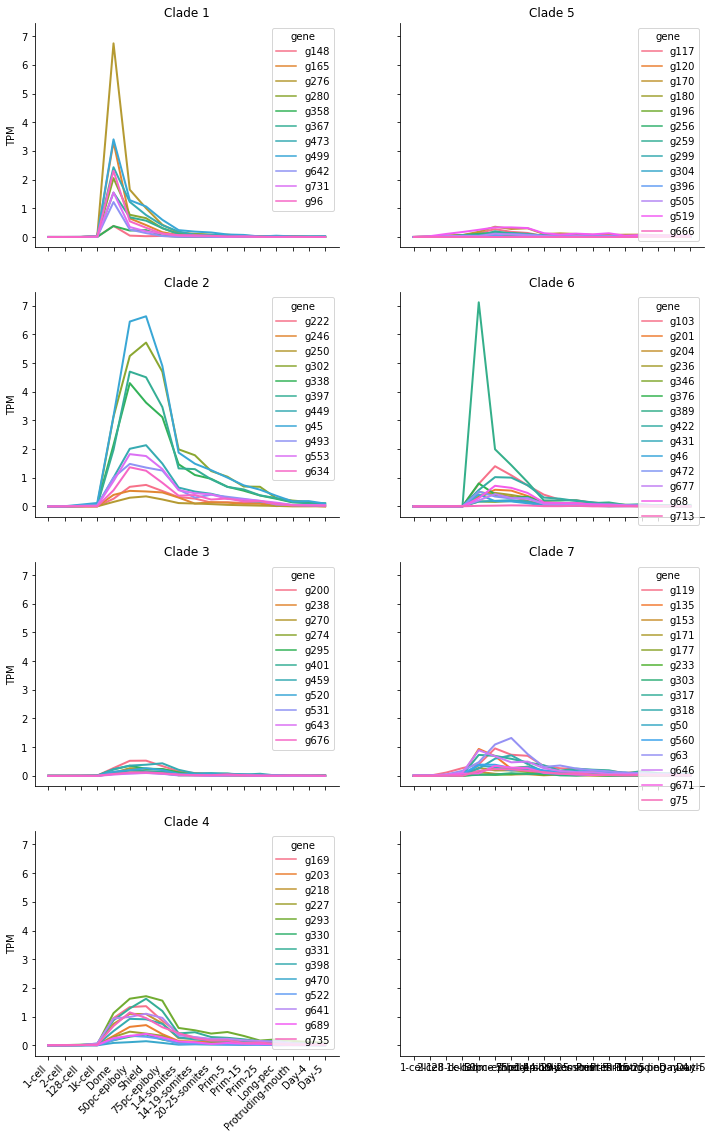

       gene clade       tpm
clade                      
1       g96     1  6.749232
2      g634     2  6.627186
3      g676     3  0.529996
4      g735     4  1.711212
5      g666     5  0.357625
6      g713     6  7.114350
7       g75     7  1.320480


In [22]:
fig, ax = plt.subplots(figsize=(12, 19), nrows=4, ncols=2, sharey=True, sharex=True)
i, j = 0, 0
for clade in sorted(set(rev_clades.values())):
    sns.lineplot(data=clades_df.loc[clades_df.clade == clade],
                 x='stageName', 
                 y='tpm', 
                 sort=False,
                 hue='gene',
#                  palette='flare',
                 lw=2,
                 ax=ax[i][j])
    ax[i][j].set_title(f'Clade {clade}')
    ax[i][j].set_ylabel('TPM')
    ax[i][j].set_xlabel('')
    ax[i][j].set_xticklabels(stageorder, rotation=45, ha='right')         
    i += 1
    if i > 3:
        j += 1
        i = 0
sns.despine()
plt.show()

## Correlation with TE expression

In [28]:
te_df = pd.read_csv('/Users/jonwells/Projects/feschottelab/drerio-tes/data/danrer11_te_summary.txt', sep='\t')
te_df = tpm_df.merge(te_df, right_on='tename', left_on='gene', how='outer')
te_df = te_df.loc[(te_df.gene.isin(finz)) | ~(te_df.tename.isnull()) & ~(te_df.tpm.isna())]
te_df['cluster'] = te_df.apply(lambda x: x.teclass if x.cluster == None else x.cluster, axis=1)
te_df['gene'] = te_df.apply(lambda x: x.tename if x.gene == None else x.gene, axis=1)

te_expressed = set(te_df.loc[te_df.tpm >= 1, 'gene'].to_list())

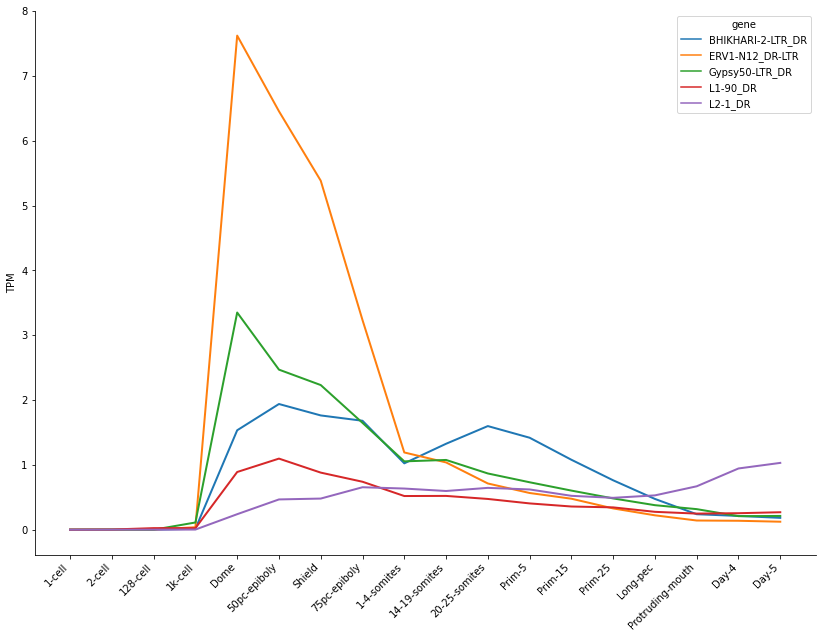

In [43]:
fig, ax = plt.subplots(figsize=(14, 10))
# sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(['ERV2_DR-LTR', 'ERV2_DR-I', 'ERV1-4_DR-LTR', 'ERV1-4_DR-I', 'ERV1_DR-LTR', 'ERV1_DR-I', 'BHIKHARI_I-int', 'BHIKHARI_LTR'])],
sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(['Gypsy50-LTR_DR', 'ERV1-N12_DR-LTR', 'BHIKHARI-2-LTR_DR', 'L1-90_DR', 'L2-1_DR'])],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             lw=2,
             ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('TPM')
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.lineplot(data=tpm_df.loc[tpm_df.gene.str.startswith('BHIKHARI')],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             lw=2,
             ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('TPM')
sns.despine()
plt.show()

In [ ]:
df = pd.read_csv('/Users/jonwells/Downloads/mart_export (3).txt', sep='\t')
pfam_df = df.groupby('Pfam ID')['Gene stable ID'].count().reset_index().sort_values('Gene stable ID', ascending=False)
znf_df = df.loc[df['Pfam ID'] == 'PF00096'].groupby('Gene stable ID')['Pfam ID'].count().reset_index()
znfs = list(znf_df['Gene stable ID'])
znf_df = df.loc[df['Gene stable ID'].isin(znfs)][['Chromosome/scaffold name', 'Gene stable ID']].drop_duplicates()
print(znf_df.loc[znf_df['Chromosome/scaffold name'] == '4'])